# Deformation Transfer

In [1]:
import igl
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import lsqr
from scipy.sparse.linalg import splu
from scipy.sparse import lil_matrix

from scipy.sparse import  diags
from scipy.sparse.linalg import spsolve

from easydict import EasyDict

from collections import defaultdict

from matplotrender import *
from utils.ict_face_model import ICT_face_model

In [277]:
def rescale(V1 ,V2):
    """rescale V1 to V2"""
    V1mean = (V1.max(0)+V1.min(0))*0.5
    V2mean = (V2.max(0)+V2.min(0))*0.5
    V = (V1-V1mean)/max(V1.max(0)-V1.min(0)) * max(V2.max(0)-V2.min(0)) + V2mean
    return V

def get_centroids(x):
    L = x.shape[0]
    return x.sum(0) / (L+1)

def get_triangle_normal(VF):
    E1 = VF[:,1] - VF[:,0]
    E2 = VF[:,2] - VF[:,0]

    Vn = np.cross(E1, E2)
    Vn = Vn / np.linalg.norm(Vn, axis=-1)[:,None]
    return Vn

def get_triangle_basis(V,F):
    VF = V[F]
    E1 = VF[:,1] - VF[:,0]
    E2 = VF[:,2] - VF[:,0]

    # Vn = np.cross(E1, E2)
    # Vn = Vn/np.linalg.norm(Vn, axis=-1)[:,None]
    Vn = get_triangle_normal(VF)
    
    # V4 = Vn + VF[:,0]
    # returns [V2-V1, V3-V1, V4-V1]
    return np.stack([E1, E2, Vn], axis=1).transpose(0,2,1)
    
def lu_factor_ata(A):
    AtA = A.T @ A
    lu = splu(AtA.tocsc())
    return lu

def fast_get_adj_triangle(F):
    """
    Return a list of adjacent triangle indices per triangle.
    F: (T,3) array of triangle indices.
    """
    edge_dict = defaultdict(list)
    for t_idx, tri in enumerate(F):
        edges = [(min(tri[i], tri[(i+1)%3]), max(tri[i], tri[(i+1)%3])) for i in range(3)]
        for edge in edges:
            edge_dict[edge].append(t_idx)

    adj_list = [[] for _ in range(len(F))]
    for t_indices in edge_dict.values():
        if len(t_indices) < 2:
            continue
        for i in t_indices:
            for j in t_indices:
                if i != j and j not in adj_list[i]:
                    adj_list[i].append(j)
    return adj_list


def creat_A_csr_matrix(V, F, INV_MAT):
    rows = []
    cols = []
    data = []

    T = F.shape[0]
    N = V.shape[0]

    # T (num triangle) x 3 (v indicies) x 3 (xyz coordinates)
    INV_MAT = INV_MAT.transpose(0,2,1)
    COEFF = np.concatenate((
            -INV_MAT[:, :, 0:2].sum(-1, keepdims=True), 
            INV_MAT[:, :, 0:2]
        ), axis = -1)
                    
    R_=3
    C_=3
    for i, H in enumerate(COEFF): # foreach T
        # H : coeff mat 3x3            
        for r in range(R_):
            for c in range(C_): # foreach xyz
                for k, v_j in enumerate(F[i]): 
                    # v_j: vertex indicies in triangle
                    # k: num indicies (0, 1, 2)
                    cols.append(C_*v_j+c)
                    rows.append(9*i+R_*r+c)                
                    data.append(H[r,k])
                    
    return sp.csr_matrix((data, (rows, cols)), shape=(T * 3 * R_, N * C_))

def creat_A_csr_matrix_34(V, F, INV_MAT, W=1.0):
    rows = []
    cols = []
    data = []

    T = F.shape[0]
    N = V.shape[0]

    INV_MAT = INV_MAT.transpose(0,2,1)
    COEFF = np.concatenate((
        -INV_MAT.sum(-1, keepdims=True),
         INV_MAT
    ), axis=-1)

    R_, C_ = 3, 3
    for i, H in enumerate(COEFF):  # H: (3,4)
        for r in range(R_):
            for c in range(C_):
                row_idx = 9*i + R_*r + c
                # vertex terms (v1~v3 + v4)
                cols.extend([C_*F[i][k] + c for k in range(3)]+[C_*N + c + 3*i])
                rows.extend([row_idx]*3+[row_idx])
                data.extend([W*H[r, k] for k in range(3)]+[H[r, 3]])

    MAT = sp.csr_matrix((data, (rows, cols)), shape=(3 * R_ * T, (C_ * N) + (C_ * T)))
    return MAT

def creat_A_csr_matrix_34_marker(V, F, src_m, tgt_m, V_tgt, W=1.0, return_RHS=False):
    """
    V, F: source vertices, triangles
    src_m: source marker
    tgt_m: source marker
    V_tgt: target vertices
    """
    N_m = len(src_m)
    assert len(src_m) == len(tgt_m)
    rows = []
    cols = []
    data = []

    T = F.shape[0]
    N = V.shape[0]

    # R_, C_ = 3, 3
    I_ = 3
    for i, s_m in enumerate(src_m):  # H: (3,4)
        t_m = tgt_m[i]
        # vertex terms (v1~v3 + v4)
        cols.extend([I_*s_m + r for r in range(3)])
        rows.extend([I_*i + r for r in range(3)])
        data.extend([W*V_tgt[t_m][r] for r in range(3)])
    MAT = sp.csr_matrix((data, (rows, cols)), shape=(I_ * N_m, (I_ * N) + (I_ * T)))
    # MAT = sp.csr_matrix((data, (rows, cols)), shape=(R_ * 3 * T, (C_ * N) + (C_ * T)))
    if return_RHS:
        RHS = V_tgt[np.array(tgt_m)].reshape(-1) * W
        return MAT, RHS
    return MAT


def creat_A_csr_matrix_34_marker2(V, F, src_m, tgt_m, V_tgt, W=1.0, return_RHS=False):
    """
    V, F: source vertices, triangles
    src_m: source marker
    tgt_m: source marker
    V_tgt: target vertices
    """
    N_m = len(src_m)
    assert len(src_m) == len(tgt_m)
    
    rows = []
    cols = []
    data = []

    T = F.shape[0]
    N = V.shape[0]

    if return_RHS:
        RHS = np.zeros(V.shape)
        
    is_marker = np.zeros(V.shape[0])
    is_marker[src_m] = 1
    
    I_ = 3
    j = 0
    for i, v_pos in enumerate(V):
        if is_marker[i] != 0:
            s_m = src_m[j]
            t_m = tgt_m[j]
            val = V_tgt[t_m]
            j = j + 1
        else:
            # val = np.array([0,0,0])
            val = v_pos
            
        if return_RHS:
            RHS[i] = val
            
        cols.extend([I_*s_m + r for r in range(I_)])
        rows.extend([I_*i + r for r in range(I_)])
        data.extend([W*val[r] for r in range(I_)])
        
    MAT = sp.csr_matrix((data, (rows, cols)), shape=(I_ * N, (I_ * N) + (I_ * T)))
    # MAT = sp.csr_matrix((data, (rows, cols)), shape=(R_ * 3 * T, (C_ * N) + (C_ * T)))
    if return_RHS:
        #RHS = V_tgt[np.array(tgt_m)].reshape(-1)
        return MAT, RHS * W
    return MAT
    
def creat_A_csr_matrix_34_adj_triangle(V, F, INV_MAT, W=1.0, return_RHS=False):
    rows = []
    cols = []
    data = []

    T = F.shape[0]
    N = V.shape[0]

    adj_list = fast_get_adj_triangle(F)

    INV_MAT = INV_MAT.transpose(0,2,1)
    COEFF = np.concatenate((
        -INV_MAT.sum(-1, keepdims=True),
         INV_MAT
    ), axis=-1)

    R_, C_ = 3, 3
    for i, adj_tri in enumerate(adj_list):
        deg = len(adj_tri)
        coeff_i = COEFF[i]
        F_i = F[i]

        for r in range(R_):
            for c in range(C_):
                row_idx = 9*i + R_*r + c

                # i triangle: v1~v3 + ghost
                cols.extend([C_*v + c for v in F_i] + [C_*N + c + 3*i])
                rows.extend([row_idx]*4)
                data.extend([W*deg * coeff_i[r, k] for k in range(3)] + [W*deg * coeff_i[r, 3]])

                for j in adj_tri:
                    coeff_j = COEFF[j]
                    F_j = F[j]
                    cols.extend([C_*v + c for v in F_j] + [C_*N + c + 3*j])
                    rows.extend([row_idx]*4)
                    data.extend([-W*coeff_j[r, k] for k in range(3)] + [-W*coeff_j[r, 3]])

    MAT = sp.csr_matrix((data, (rows, cols)), shape=(3 * R_ * T, (C_ * N) + (C_ * T)))
    if return_RHS:
        RHS = np.zeros((3 * R_ * T,))
        return MAT, RHS * W
    return MAT

def get_adj_triangles(F):
    """
    Build adjacency for each triangle: map triangle index -> set of neighboring triangle indices
    """
    # Collect triangles incident on each vertex
    tri_per_v = {v: set() for v in np.unique(F)}
    for t, tri in enumerate(F):
        for v in tri:
            tri_per_v[v].add(t)
    # Build adjacency
    adj = {t: set() for t in range(len(F))}
    for verts, tris in tri_per_v.items():
        tris = list(tris)
        for i in range(len(tris)):
            for j in range(i+1, len(tris)):
                t1, t2 = tris[i], tris[j]
                adj[t1].add(t2)
                adj[t2].add(t1)
    return adj


def build_smoothness_A(V, F, V_inv, wS=1.0):
    """
    Assemble the sparse A matrix for the deformation smoothness term:
      E_S = sum_{(i,j)} ||T_i - T_j||_F^2
    where T_t = ([v2-v1, v3-v1]) @ V_inv[t].

    Parameters:
      V     : (N,3) source vertices
      F     : (T,3) triangle indices
      V_inv : (T,3,3) precomputed inverse of local bases (V^-1)
      wS    : weight for smoothness

    Returns:
      A     : sparse CSR of shape (#equations, 3*N)
    """
    N = V.shape[0]
    adj = get_adj_triangles(F)
    weight = np.sqrt(wS)

    rows, cols, data = [], [], []
    row = 0

    # For each unordered adjacent pair (i<j)
    for i, neighs in adj.items():
        for j in neighs:
            if j <= i:
                continue
            inv_i = V_inv[i]
            inv_j = V_inv[j]
            # For each scalar equation (p,q entry of T_i - T_j = 0)
            for p in range(3):
                for q in range(3):
                    # coefficients for tri i: [-3, +1, +1] * inv_i[q,p]
                    coefs_i = [-3*inv_i[q,p], inv_i[q,p], inv_i[q,p]]
                    for k, vid in enumerate(F[i]):
                        rows.append(row)
                        cols.append(3*vid + p)
                        data.append(coefs_i[k] * weight)
                    # coefficients for tri j: same pattern, then negated
                    coefs_j = [-3*inv_j[q,p], inv_j[q,p], inv_j[q,p]]
                    for k, vid in enumerate(F[j]):
                        rows.append(row)
                        cols.append(3*vid + p)
                        data.append(-coefs_j[k] * weight)
                    row += 1

    A = sp.coo_matrix((data, (rows, cols)), shape=(row, 3*N)).tocsr()
    return A

def look_triangle_has_v(vtx_idx, tri_idx, F):
    holds = []
    for idx, triangle in enumerate(F[:tri_idx]):
        for vidx in triangle:
            if vtx_idx == vidx:
                holds.append(idx)
                
    for idx, triangle in enumerate(F[tri_idx+1:]):
        for vidx in triangle:
            if vtx_idx == vidx:
                holds.append(idx+tri_idx+1)
    return holds

def get_adj_triangle_mat(F):
    mat = np.zeros([len(F), len(F)])

    for i in range(len(F)):
        js=[]
        for vidx in F[i]:
            j_list = look_triangle_has_v(vidx, i, F)
            js += j_list
        js = list(set(js))
        mat[i,i] = len(js)
        mat[i, js] = -1
    return mat
    
def get_adj_triangle(F):
    mat = []
    for i in range(len(F)):
        js=[]
        for vidx in F[i]:
            j_list = look_triangle_has_v(vidx, i, F)
            js += j_list
        js = list(set(js))
        mat.append(js)
    return mat
    
def build_edge_to_tri_map(F):
    """
    Args:
        F: (F, 3) 배열
        
    Returns: 
        (dict) { (min(v1,v2), max(v1,v2)): [tri_idx1, tri_idx2, ...], ... }
    """
    
    edge2tri = defaultdict(list)
    for i, tri in enumerate(F):
        v0, v1, v2 = tri
        edges = [
            tuple(sorted((v0, v1))),
            tuple(sorted((v1, v2))),
            tuple(sorted((v2, v0)))
        ]
        for e in edges:
            edge2tri[e].append(i)
    return edge2tri

def get_edge_adj_matrix(F):
    edge2tri = build_edge_to_tri_map(F)

    T = len(F)
    mat = np.zeros((T, T), dtype=int)

    # Find adjacent triangle j for each triangle i
    for i, tri in enumerate(F):
        adj_set = set()
        v0, v1, v2 = tri
        edges = [
            tuple(sorted((v0, v1))),
            tuple(sorted((v1, v2))),
            tuple(sorted((v2, v0)))
        ]
        for e in edges:
            for nbr_tri in edge2tri[e]:
                if nbr_tri != i:
                    adj_set.add(nbr_tri)

        mat[i, i] = len(adj_set)
        for j in adj_set:
            mat[i, j] = -1

    return mat

def get_adj_triangle_mat_edge_sparse(F):

    edge2tri = build_edge_to_tri_map(F)
    T = len(F)
    mat = lil_matrix((9*T, 9*T), dtype=int)

    for i, tri in enumerate(F):
        adj_set = set()
        v0, v1, v2 = tri
        edges = [
            tuple(sorted((v0, v1))),
            tuple(sorted((v1, v2))),
            tuple(sorted((v2, v0)))
        ]
        for e in edges:
            for nbr_tri in edge2tri[e]:
                if nbr_tri != i:
                    adj_set.add(nbr_tri)

        mat[9*i:9*i+9, 9*i:9*i+9] = len(adj_set)*np.eye(9)
        for j in adj_set:
            mat[9*i:9*i+9, 9*j:9*j+9] = -1*np.eye(9)
    return mat.tocsr()

def smooth(vert, lap, loop=1, t=0.01):
    D_Inv = diags(1 / lap.diagonal())
    _lap = D_Inv @ lap
    
    # a = 1-t
    I_L = sp.identity(lap.shape[0]) - _lap*t
    # I_L = (I_L*t).power(loop)
    for i in range(loop):
        I_L = I_L @ I_L
    
    vert = I_L @ vert
    return vert

def random_rotation_matrix(randgen=None):
    """
    Borrowed from https://github.com/nmwsharp/diffusion-net/blob/master/src/diffusion_net/utils.py
    
    Creates a random rotation matrix.
    randgen: if given, a np.random.RandomState instance used for random numbers (for reproducibility)
    """
    # adapted from http://www.realtimerendering.com/resources/GraphicsGems/gemsiii/rand_rotation.c
    
    if randgen is None:
        randgen = np.random.RandomState()
        
    theta, phi, z = tuple(randgen.rand(3).tolist())
    
    theta = theta * 2.0*np.pi  # Rotation about the pole (Z).
    phi = phi * 2.0*np.pi  # For direction of pole deflection.
    z = z * 2.0 # For magnitude of pole deflection.
    
    # Compute a vector V used for distributing points over the sphere
    # via the reflection I - V Transpose(V).  This formulation of V
    # will guarantee that if x[1] and x[2] are uniformly distributed,
    # the reflected points will be uniform on the sphere.  Note that V
    # has length sqrt(2) to eliminate the 2 in the Householder matrix.
    
    r = np.sqrt(z)
    Vx, Vy, Vz = V = (
        np.sin(phi) * r,
        np.cos(phi) * r,
        np.sqrt(2.0 - z)
        )
    
    st = np.sin(theta)
    ct = np.cos(theta)
    
    R = np.array(((ct, st, 0), (-st, ct, 0), (0, 0, 1)))
    # Construct the rotation matrix  ( V Transpose(V) - I ) R.

    M = (np.outer(V, V) - np.eye(3)).dot(R)
    return M
    
def random_rotate_points(pts, randgen=None, return_rot=False):
    R = random_rotation_matrix(randgen) 
    if return_rot:
        return np.matmul(pts, R), R
    return np.matmul(pts, R)


def build_correspondence_system(V_src, F_src, c_pts, marker_idx, marker_pos,
                                wS=1.0, wI=0.001, wC=1.0):
    """
    Assemble the weighted least‐squares system for Section 5 correspondence.

    Inputs:
      V_src      : (n,3) undeformed source vertices
      F_src      : (m,3) source triangle indices
      c_pts      : (n,3) closest valid points on target for each source vertex
      marker_idx : length‐M list of source vertex indices with exact constraints
      marker_pos : (M,3) corresponding target positions
      wS, wI, wC : weights for smoothness, identity, and closest‐point terms

    Returns:
      A : sparse ((rows)×(3n)) system matrix
      b : (rows,3) right‐hand side
    """

    nV = V_src.shape[0]
    nT = F_src.shape[0]

    # 1) Precompute per‐triangle inverse bases: V_inv[i] maps Δv_src→transform
    V0 = V_src[F_src[:,0]]
    V2 = V_src[F_src[:,1:]] - V0[:,None,:]      # shape (m,3,3)
    V_inv = np.linalg.inv(V2)                  # (m,3,3)

    # 2) Build adjacency list for triangles
    tri_per_v = [[] for _ in range(nV)]
    for t in range(nT):
        for v in F_src[t]:
            tri_per_v[v].append(t)
    adj_tris = {t:set() for t in range(nT)}
    for v,tris in enumerate(tri_per_v):
        for i in tris:
            for j in tris:
                if i < j:
                    adj_tris[i].add(j)
                    adj_tris[j].add(i)

    rows = []
    cols = []
    data = []
    rhs = []

    def add_eq(row_coefs, rhs_val, weight):
        # row_coefs : list of (vertex_index, scalar) pairs
        # weight    : scalar weight to multiply both sides
        r = len(rhs)
        for vid,coef in row_coefs:
            # x,y,z share same coef
            cols.extend([3*vid, 3*vid+1, 3*vid+2])
            rows.extend([r,r,r])
            data.extend([coef*weight]*3)
        rhs.extend([rhs_val[0]*weight, rhs_val[1]*weight, rhs_val[2]*weight])

    ### A) Closest‐point term:  for each vertex i ->  \tilde v_i = c_i
    for i in range(nV):
        add_eq([(i, 1.0)], c_pts[i], weight=np.sqrt(wC))

    ### B) Marker constraints:  \tilde v_{s_k} = marker_pos[k]
    for k, vid in enumerate(marker_idx):
        add_eq([(vid, 1.0)], marker_pos[k], weight=1e6)
        # large weight enforces it as a hard constraint

    ### C) Deformation identity term:
    #    For each triangle t, flatten (T_t - I)=0 into 9 scalar equations.
    #    T_t = ([v2-v1, v3-v1, v4-v1] * V_inv[t]) so each row_coefs is 3 v~'s.
    I3 = np.eye(3)
    for t in range(nT):
        vid0,vid1,vid2 = F_src[t]
        inv_t = V_inv[t]   # shape (3,3)
        # the mapping from [v1,v2,v3,v4] to Q = ([v2-v1, v3-v1, v4-v1]) @ inv_t
        # yields for each of the 9 entries an equation in the 4 vertices.
        # We expand for the three vertices:
        for p in range(3):
            for q in range(3):
                # coefficient for v1:  -(inv_t[q,p] + inv_t[q,p] + inv_t[q,p])  
                #  (since v2-v1, v3-v1, v4-v1 all involve -v1)
                coef_v1 = - (inv_t[q,p]*3)
                # for v2: +inv_t[q,p] ; v3: +inv_t[q,p]; v4: +inv_t[q,p]
                coef_v2 = inv_t[q,p]
                coef_v3 = inv_t[q,p]
                coef_v4 = inv_t[q,p]
                # subtract identity I3[p,q]
                rhs_val = np.array([0,0,0],float)
                # Actually each scalar eq only affects one coordinate:
                # Here we assign it to coordinate p of the rhs.
                rhs_val[p] = I3[p,q]
                row_coefs = [
                    (vid0, coef_v1),
                    (vid1, coef_v2),
                    (vid2, coef_v3),
                    # note: we treat the "fourth" undeformed vertex = vid0 again
                    # Sum of three edges includes v0 three times.
                    # (strictly one should introduce an extra dummy vertex per tri;
                    #  but for clarity we fold it back into v0)
                ]
                add_eq(row_coefs, rhs_val, weight=np.sqrt(wI))

    ### D) Deformation smoothness term:
    #    For each adjacent triangle pair (i,j), flatten (T_i - T_j)=0 into 9 eq.
    for i, neigh in adj_tris.items():
        vidsi = F_src[i]
        inv_i = V_inv[i]
        for j in neigh:
            vidsj = F_src[j]
            inv_j = V_inv[j]
            # for each of 9 entries:
            for p in range(3):
                for q in range(3):
                    # build equation: (sum_k [edge-coefs]_i * v~_k) - (sum_k [edge-coefs]_j * v~_k) = 0
                    # where edge-coefs derive from inv_i and inv_j exactly as in identity term
                    ci0 = -inv_i[q,p]*3
                    ci1 = inv_i[q,p]
                    ci2 = inv_i[q,p]
                    cj0 = -inv_j[q,p]*3
                    cj1 = inv_j[q,p]
                    cj2 = inv_j[q,p]
                    row_coefs = [
                        (vidsi[0],  ci0),
                        (vidsi[1],  ci1),
                        (vidsi[2],  ci2),
                        (vidsj[0], -cj0),
                        (vidsj[1], -cj1),
                        (vidsj[2], -cj2),
                    ]
                    add_eq(row_coefs, np.zeros(3), weight=np.sqrt(wS))

    # assemble into a sparse matrix
    A = sp.coo_matrix((data,(rows,cols)),shape=(len(rhs),3*nV)).tocsr()
    b = np.array(rhs).reshape(-1,3)
    return A, b


## Example code to create A matrix

In [166]:
   
#V, F, INV_MAT = np.random.rand((5,3)), np.random.randint(1,5,(4,3))
NUM_V = 4
V = np.random.randint(1,NUM_V,(6,1)).repeat(3,1)
# V = np.random.randint(0,3,(3,3))
# F = np.array([[0,1,2]])
# F = np.array([[0,2,3],[1,2,5],[0,4,5]])
# F = np.array([[0,1,3],[1,2,3]])
F = np.array([[0,1,2],[0,2,3],[0,3,1],[1,3,2]])

T=F.shape[0]
N=V.shape[0]
INV_MAT = np.random.randint(0,NUM_V,(T,3,3))
INV_MAT

array([[[3, 1, 3],
        [2, 3, 2],
        [0, 2, 3]],

       [[3, 3, 1],
        [2, 0, 2],
        [1, 0, 0]],

       [[1, 2, 2],
        [2, 3, 0],
        [0, 2, 3]],

       [[2, 1, 2],
        [1, 2, 0],
        [1, 2, 0]]])

In [167]:
# INV_MAT
COEFF = np.concatenate((
            -INV_MAT.sum(-1, keepdims=True), 
            INV_MAT
        ), axis = -1)
COEFF

array([[[-7,  3,  1,  3],
        [-7,  2,  3,  2],
        [-5,  0,  2,  3]],

       [[-7,  3,  3,  1],
        [-4,  2,  0,  2],
        [-1,  1,  0,  0]],

       [[-5,  1,  2,  2],
        [-5,  2,  3,  0],
        [-5,  0,  2,  3]],

       [[-5,  2,  1,  2],
        [-3,  1,  2,  0],
        [-3,  1,  2,  0]]])

In [146]:
V

array([[2, 2, 2],
       [2, 2, 2],
       [1, 1, 1],
       [1, 1, 1],
       [2, 2, 2],
       [1, 1, 1]])

In [147]:
adj_list = get_adj_triangle_mat(F)
adj_list


array([[ 1., -1.],
       [-1.,  1.]])

In [168]:
# adj_list = get_adj_triangle_mat(F)
adj_list = get_adj_triangle(F)
adj_list


[[1, 2, 3], [0, 2, 3], [0, 1, 3], [0, 1, 2]]

In [151]:
AA = creat_A_csr_matrix_34_adj_triangle(V, F, INV_MAT)
AA.shape

(18, 24)

In [150]:
# AA = creat_A_csr_matrix_34_adj_triangle(V, F, INV_MAT)
AA = creat_A_csr_matrix_34(V, F, INV_MAT)
print(AA.shape)
AA.todense()

(18, 24)


matrix([[-4,  0,  0,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  1,  0,  0,  0,  0,  0],
        [ 0, -4,  0,  0,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  1,  0,  0,  0,  0],
        [ 0,  0, -4,  0,  0,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  1,  0,  0,  0],
        [-4,  0,  0,  1,  0,  0,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,
          0,  0,  1,  0,  0,  0,  0,  0],
        [ 0, -4,  0,  0,  1,  0,  0,  0,  0,  0,  2,  0,  0,  0,  0,  0,
          0,  0,  0,  1,  0,  0,  0,  0],
        [ 0,  0, -4,  0,  0,  1,  0,  0,  0,  0,  0,  2,  0,  0,  0,  0,
          0,  0,  0,  0,  1,  0,  0,  0],
        [-2,  0,  0,  0,  0,  0,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0],
        [ 0, -2,  0,  0,  0,  0,  0,  0,  0,  0,  2,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0, -2,  0,  0,  0,  0,  0,  0,  0,  0,  2,  0,  0,  0,  0,
       

In [125]:
# INV_MAT
COEFF = np.concatenate((
            -INV_MAT.sum(-1, keepdims=True), 
            INV_MAT
        ), axis = -1)

rows = []
cols = []
data = []
rhs = []

def add_eq(row_coefs, rhs_val, weight):
    # row_coefs : list of (vertex_index, scalar) pairs
    # weight    : scalar weight to multiply both sides
    r = len(rhs)
    for l in range(3):
        for vid, coef in row_coefs:
            
            # x,y,z share same coef
            cols.append(3*vid+l)
            rows.append(r)
            data.append(coef*weight)
            # print(sp.coo_matrix((data,(rows,cols)),shape=(i,3*NUM_V)).todense())
            
        rhs.append(rhs_val[l]*weight)
    
adj_list = get_adj_triangle(F)
for i, neigh in enumerate(adj_list):
    vidsi = F[i]
    inv_i = INV_MAT[i]
    for j in neigh:
        vidsj = F[j]
        inv_j = INV_MAT[j]
        # for each of 9 entries:
        for p in range(3):
            for q in range(3):
                # build equation: (sum_k [edge-coefs]_i * v~_k) - (sum_k [edge-coefs]_j * v~_k) = 0
                # where edge-coefs derive from inv_i and inv_j exactly as in identity term
                ci0 = -inv_i[q,p]*3
                ci1 = inv_i[q,p]
                ci2 = inv_i[q,p]
                cj0 = -inv_j[q,p]*3
                cj1 = inv_j[q,p]
                cj2 = inv_j[q,p]
                row_coefs = [
                    (vidsi[0],  ci0),
                    (vidsi[1],  ci1),
                    (vidsi[2],  ci2),
                    (vidsj[0], -cj0),
                    (vidsj[1], -cj1),
                    (vidsj[2], -cj2),
                ]
                # print(row_coefs)
                add_eq(row_coefs, np.zeros(3), weight=np.sqrt(1))
                # break
A = sp.coo_matrix((data,(rows,cols)),shape=(len(rhs),3*NUM_V+3*T)).tocsr()
print(i, neigh)
# row_coefs
print(A.shape)
A.todense()
# print(INV_MAT)

1 [0]
(54, 18)


matrix([[  0.,   0.,   0.,   3.,   3.,   3.,  -1.,  -1.,  -1.,  -1.,
          -1.,  -1.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ -9.,  -9.,  -9.,   3.,   3.,   3.,   0.,   0.,   0.,   3.,
           3.,   3.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ -9.,  -9.,  -9.,   3.,   3.,   3.,   0.,   0.,   0.,   3.,
           3.,   3.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0

In [ ]:
rows = []
cols = []
data = []

T = F.shape[0]
N = V.shape[0]

print("num T:", T)
print("num N:", N)

# T (num triangle) x 3 (v indicies) x 3 (xyz coordinates)
COEFF = INV_MAT.transpose(0,2,1)
# COEFF = np.concatenate((
#         -INV_MAT.sum(-1, keepdims=True), 
#         INV_MAT[:, :, 0:2]
#     ), axis = -1)

R_=3
C_=3

#VN = get_triangle_normal(V[F])

for i, H in enumerate(COEFF): # foreach T
    # H : coeff mat 3x3
    print(H)
        
    for r in range(R_):
        for c in range(C_): # foreach xyz+d
            for k, v_i in enumerate(F[i]): 
                # v_i: v indicies
                # k: num indicies (0, 1, 2)
                cols.append(C_*v_i+c)
                rows.append(9*i+R_*r+c)                
                data.append(H[r,k])
        
            # for V4 
            cols.append(3*i+C_*N+c)
            rows.append(9*i+R_*r+c)
            data.append(H[r, 3])

MAT = sp.csr_matrix((data, (rows, cols)), shape=(3 * R_ * T, (C_ * N) + (C_ * T)))

print(MAT.todense().astype(int))
# np.savetxt('test.txt', MAT.todense().astype(int))   # X is an array
print(V.reshape(-1)[None])


num T: 2
num N: 6
[[19 17  8  8]
 [17  3 12  2]
 [11  9 13  4]]
[[ 3 12  8  0]
 [ 2 18 19  9]
 [ 6  6  7 14]]
[[19  0  0  0  0  0 17  0  0  8  0  0  0  0  0  0  0  0  8  0  0  0  0  0]
 [ 0 19  0  0  0  0  0 17  0  0  8  0  0  0  0  0  0  0  0  8  0  0  0  0]
 [ 0  0 19  0  0  0  0  0 17  0  0  8  0  0  0  0  0  0  0  0  8  0  0  0]
 [17  0  0  0  0  0  3  0  0 12  0  0  0  0  0  0  0  0  2  0  0  0  0  0]
 [ 0 17  0  0  0  0  0  3  0  0 12  0  0  0  0  0  0  0  0  2  0  0  0  0]
 [ 0  0 17  0  0  0  0  0  3  0  0 12  0  0  0  0  0  0  0  0  2  0  0  0]
 [11  0  0  0  0  0  9  0  0 13  0  0  0  0  0  0  0  0  4  0  0  0  0  0]
 [ 0 11  0  0  0  0  0  9  0  0 13  0  0  0  0  0  0  0  0  4  0  0  0  0]
 [ 0  0 11  0  0  0  0  0  9  0  0 13  0  0  0  0  0  0  0  0  4  0  0  0]
 [ 0  0  0  3  0  0 12  0  0  0  0  0  0  0  0  8  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  3  0  0 12  0  0  0  0  0  0  0  0  8  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  3  0  0 12  0  0  0  0  0  0  0  0  8  0  0  0 

In [12]:

F = np.array([[0,1,2],[0,2,3],[0,3,1],[1,3,2],[1,3,5]])

In [15]:
adjF = get_edge_adj_matrix(F)
# print(adjF[:3, :12])
print(adjF)
print(adjF.shape, F.shape)

[[ 3 -1 -1 -1  0]
 [-1  3 -1 -1  0]
 [-1 -1  4 -1 -1]
 [-1 -1 -1  4 -1]
 [ 0  0 -1 -1  2]]
(5, 5) (5, 3)


In [16]:
aaa = get_edge_adj_matrix(F)
print(aaa)

[[ 3 -1 -1 -1  0]
 [-1  3 -1 -1  0]
 [-1 -1  4 -1 -1]
 [-1 -1 -1  4 -1]
 [ 0  0 -1 -1  2]]


In [86]:
adjF = get_adj_triangle_mat_edge_sparse(F)
print(adjF.shape)
print(adjF[:15, :15].todense())

(36, 36)
[[ 3  0  0  0  0  0  0  0  0 -1  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  0  0 -1  0  0  0  0]
 [ 0  0  3  0  0  0  0  0  0  0  0 -1  0  0  0]
 [ 0  0  0  3  0  0  0  0  0  0  0  0 -1  0  0]
 [ 0  0  0  0  3  0  0  0  0  0  0  0  0 -1  0]
 [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0 -1]
 [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  3  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  3  0  0  0  0  0  0]
 [-1  0  0  0  0  0  0  0  0  3  0  0  0  0  0]
 [ 0 -1  0  0  0  0  0  0  0  0  3  0  0  0  0]
 [ 0  0 -1  0  0  0  0  0  0  0  0  3  0  0  0]
 [ 0  0  0 -1  0  0  0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0 -1  0  0  0  0  0  0  0  0  3  0]
 [ 0  0  0  0  0 -1  0  0  0  0  0  0  0  0  3]]


### save as textfile to check if it is right!

In [246]:
np.savetxt('test.txt', A.todense())   # X is an array


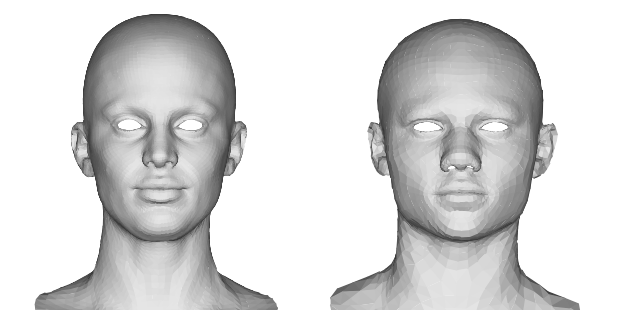

In [4]:
from matplotrender import *
# figure size
SIZE = 3
mesh_scale = .7

srcV, srcF = igl.read_triangle_mesh("data/source_restpose_mesh.obj")
newV, newF = igl.read_triangle_mesh("data/target_restpose_mesh.obj")

v_list=[ srcV, newV ]
v_list=[ v*mesh_scale for v in v_list]
f_list=[ srcF, newF ]

# xyz Euler angle to rotate the mesh
rot_list=[ [0,0,0] ]*len(v_list)
plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='shade')

In [128]:
# source rest pose
V_S = get_triangle_basis(srcV, srcF)
V_S_INV = np.linalg.inv(V_S)
print(V_S_INV.shape)

As = creat_A_csr_matrix_34(srcV, srcF, V_S_INV)
print("A shape (9T x 3N+3T)", As.shape)
lu = lu_factor_ata(As)

adjM = get_adj_triangle_mat_edge_sparse(srcF)
A_Es=adjM @ As

NameError: name 'srcV' is not defined

In [6]:
# def build_smooth_optimization_term(V_span, F, adjF, A, ws=1):
V_span, F, adjF, A = V_S, srcF, adjM, As
ws=1
# num of src mesh faces
num_f = len(F)
# build a [3f, 3f] Identity matrix
id_mat_3fby3f = sp.identity(n=9 * num_f, format='csc')
print(id_mat_3fby3f.shape)
print(adjF.shape)

# build the left-side (input) matrix of the linear equation, it's a [n, n] mat
mat_tmp = (id_mat_3fby3f - adjF).dot(A)
left_mat = (mat_tmp.transpose()).dot(mat_tmp)
# build the right-side (target) matrix of the linear equation, it's a all-zero matrix with shape [n, 3]
np_row, np_col, np_val = np.array([]), np.array([]), np.array([])
right_mat = sp.csc_matrix((np_val, (np_row, np_col)), shape=(len(V_span), 3))
# build the weight matrix
ws_mat = sp.identity(n=len(V_span), format='csc').multiply(2.0 * ws)
    # return left_mat, right_mat, ws_mat

(200592, 200592)
(200592, 200592)


In [7]:
left_mat.todense()

MemoryError: Unable to allocate 75.4 GiB for an array with shape (100608, 100608) and data type float64

In [96]:
left_mat, right_mat, ws_mat = build_smooth_optimization_term(V_S, srcF, adjM, As, ws=1)

ValueError: inconsistent shapes

In [49]:
# adjM = get_adj_triangle_mat(srcF)
adj = get_edge_adj_matrix(srcF)
print(adj.shape)
print(adj[0:3, :6])

(22288, 22288)
[[ 3 -1  0  0  0  0]
 [-1  3  0  0  0  0]
 [ 0  0  3  0  0  0]]


In [87]:
adjM = get_adj_triangle_mat_edge_sparse(srcF)

In [88]:
print(adjM.shape)
print(adjM[0:3, :12].todense())

(200592, 200592)
[[ 3  0  0  0  0  0  0  0  0 -1  0  0]
 [ 0  3  0  0  0  0  0  0  0  0 -1  0]
 [ 0  0  3  0  0  0  0  0  0  0  0 -1]]


In [89]:
A_Es=adjM @ As

In [90]:
A_Es.shape

(200592, 100608)

## Load meshes

In [278]:
## loading blendshape
ict = ICT_face_model()
blendshapes = ict.exp_basis[:,:11248]
BS = 27
print(blendshapes.shape)


tgt_mesh = EasyDict()
src_mesh = EasyDict()

print('loading meshes')
# src_mesh.v, src_mesh.f = igl.read_triangle_mesh("_tmp/m02_model.obj")
src_mesh.v, src_mesh.f = igl.read_triangle_mesh("data/source_restpose_mesh.obj")
# src_mesh.v, src_mesh.f = ict.neutral_verts, ict.faces
print('\t src vertices:', src_mesh.v.shape, '\t faces:',src_mesh.f.shape) # (11248, 3) (22288, 3)

src_mesh.motions = blendshapes[BS]#np.load(r'_tmp\040.npy')
print('\t src vertices (posed):', src_mesh.motions.shape) # (219, 11248, 3)

# newV, newF = igl.read_triangle_mesh("_tmp/m02_deformed-0.2.obj")
newV, newF = igl.read_triangle_mesh("data/m02_deformed-0.2.obj")
# newV, newF = igl.read_triangle_mesh("data/target_restpose_mesh.obj")
newV = rescale(newV, src_mesh.v)
R = np.eye(3)
# newV, R = random_rotate_points(newV, return_rot=True)


tgt_mesh.v = newV
tgt_mesh.f = newF
print('\t tgt vertices:', tgt_mesh.v.shape) # (219, 11248, 3)

(53, 11248, 3)
loading meshes
	 src vertices: (11248, 3) 	 faces: (22288, 3)
	 src vertices (posed): (11248, 3)
	 tgt vertices: (11248, 3)


In [4]:
# target rest pose
V_T = get_triangle_basis(tgt_mesh.v, tgt_mesh.f)
V_T_INV = np.linalg.inv(V_T)
print(V_T_INV.shape)

A = creat_A_csr_matrix_34(tgt_mesh.v, tgt_mesh.f, V_T_INV)
# A = creat_A_csr_matrix(tgt_mesh.v, tgt_mesh.f, V_T_INV)
print("A shape", A.shape)
lu = lu_factor_ata(A)

(22288, 3, 3)
A shape (200592, 100608)


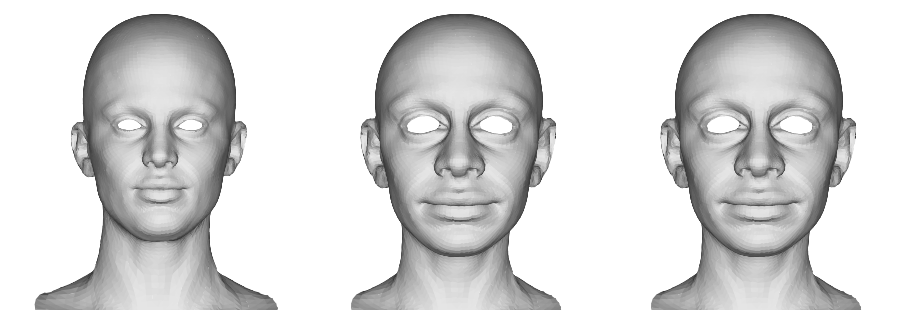

In [5]:
from matplotrender import *
# figure size
SIZE = 3
mesh_scale = .7

# mesh that you wanna render src_mesh.v, src_mesh.f
#v_list=[ src_mesh.v, src_mesh.motions[FRAME], tgt_mesh.v, V_transferred-V_transferred.mean(0)+tgt_mesh.v.mean(0)]
v_list=[ src_mesh.v, tgt_mesh.v, np.matmul(tgt_mesh.v, R.T)]
v_list=[ v*mesh_scale for v in v_list]
f_list=[ src_mesh.f ]*len(v_list)

# xyz Euler angle to rotate the mesh
rot_list=[ [0,0,0] ]*len(v_list)

# plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE)
# plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='normal')
# plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='shade',bg_black=True)
plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='shade')

## Run

In [8]:
# source rest pose ########################
V_S = get_triangle_basis(src_mesh.v, src_mesh.f)
print(V_S.shape) # (22288, 3, 3)
###########################################

# source posed ############################
#FRAME = 150
# V_S_H = get_triangle_basis(src_mesh.motions[FRAME], src_mesh.f)
# BS = 11
BS = 26
V_S_H = get_triangle_basis(blendshapes[BS]+src_mesh.v, src_mesh.f)
print(V_S_H.shape) # (22288, 3, 3)
###########################################

## a.k.a source transformation `S = V^~ @ V^-1`
V_S_INV = np.linalg.inv(V_S)
S = V_S_H @ V_S_INV
print(S.shape) # (22288, 3, 3)
###########################################


# target rest pose ########################
V_T = get_triangle_basis(tgt_mesh.v, tgt_mesh.f)
V_T_INV = np.linalg.inv(V_T)
print(V_T_INV.shape)
###########################################


# A^T A x^~ = A^T c
# x^~ = (A^T A)^-1 A^T c

Atb = A.T @ S.transpose(0,2,1).reshape(-1)
print(S.shape)
print(Atb.shape)

V_transferred = lu.solve(Atb).reshape(-1,3)
# print(V_transferred.shape)
V_transferred = V_transferred[:tgt_mesh.v.shape[0]]
# print(V_transferred.shape)

recenter = -V_transferred.mean(0)+tgt_mesh.v.mean(0)

# V_transferred = rescale(V_transferred, src_mesh.v)
# print(src_mesh.v.min(0), src_mesh.v.max(0))
# print(src_mesh.motions[FRAME].min(0), src_mesh.motions[FRAME].max(0))
# print(tgt_mesh.v.min(0), tgt_mesh.v.max(0))
# print(V_transferred.min(0), V_transferred.max(0))



(22288, 3, 3)
(22288, 3, 3)
(22288, 3, 3)
(22288, 3, 3)
(22288, 3, 3)
(100608,)


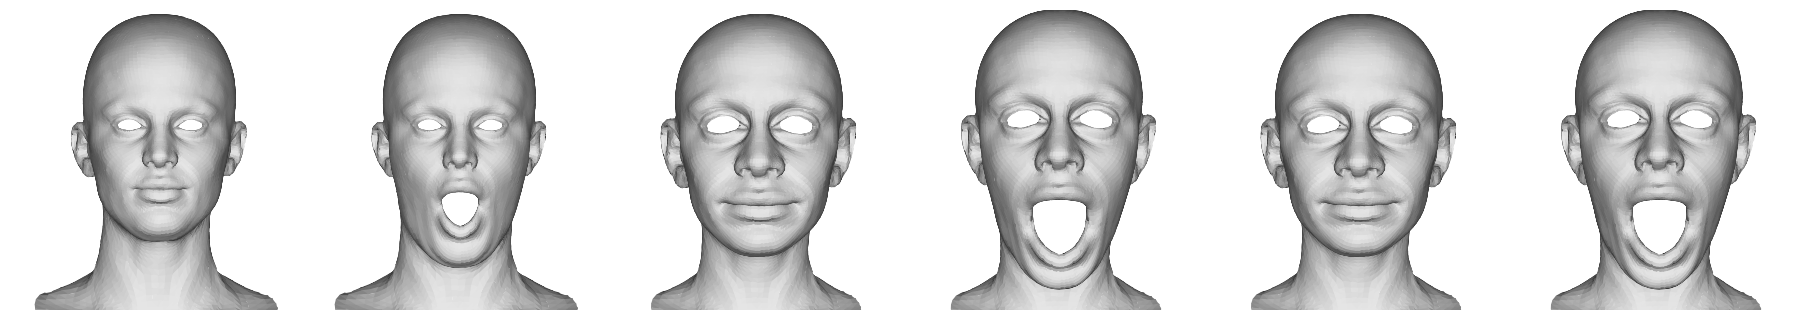

In [9]:
from matplotrender import *
# figure size
SIZE = 3
mesh_scale = .7

# mesh that you wanna render src_mesh.v, src_mesh.f
#v_list=[ src_mesh.v, src_mesh.motions[FRAME], tgt_mesh.v, V_transferred-V_transferred.mean(0)+tgt_mesh.v.mean(0)]
v_list=[ src_mesh.v, blendshapes[BS]+src_mesh.v, tgt_mesh.v, V_transferred+recenter, np.matmul(tgt_mesh.v, R.T), np.matmul(V_transferred+recenter, R.T)]
v_list=[ v*mesh_scale for v in v_list]
f_list=[ src_mesh.f ]*len(v_list)

# xyz Euler angle to rotate the mesh
rot_list=[ [0,0,0] ]*len(v_list)
# rot_list=[ [0,-10,0] ]*2+[ [43,-90,130] ]*2

# plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE)
# plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='normal')
# plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='shade',bg_black=True)
plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='shade')

# corr

In [12]:
from scipy.sparse import vstack

In [258]:
# marker
src_m = [10760, 11064, 10678, 10527, 1225, 1888, 1052, 367, 1719, 1722, 2199, 1447, 966, 3661, 4390, 3927, 3924, 2608, 3272, 4088, 3443, 268, 493, 1914, 2044, 1401, 3615, 4240, 4114, 2734, 2509, 978, 4527, 4942, 4857, 1140, 2075, 1147, 4269, 3360, 1507, 1542, 1537, 1528, 1518, 1511, 3742, 3751, 3756, 3721, 3725, 3732, 5708, 5695, 2081, 0, 4275, 6200, 6213, 6346, 6461, 5518, 5957, 5841, 5702, 5711, 5533, 6216, 6207, 6470, 5517, 5966]
src_m = np.array(src_m)
tgt_m = [ 3523,  3619,  3473,  3421,  449,  475,  131, 114,  296,  300,   79,  552, 304, 1343, 1111, 1100, 1096, 931,  949, 1261, 1253,  369, 378,  151,  726,  723, 1505, 1509, 1474,  896, 1162, 361, 1618, 1723, 1707,  440,   43,    3, 1232, 1229,  800,  267,  623,  336,  583,  209, 1384, 1028, 1181, 1005, 1372, 1375, 1897,   58,  742, 0,  924,  865, 1998, 2083, 2109, 2100, 1976, 1948, 1964, 1918, 1867, 2036, 2012, 2007, 2064, 1918]
tgt_m = np.array(tgt_m)

src_tn = get_triangle_normal(src_mesh.v[src_mesh.f])
src_vn = trimesh.geometry.mean_vertex_normals(src_mesh.v.shape[0], src_mesh.f, src_tn)
tgt_tn = get_triangle_normal(tgt_mesh.v[tgt_mesh.f])
tgt_vn = trimesh.geometry.mean_vertex_normals(tgt_mesh.v.shape[0], tgt_mesh.f, tgt_tn)

print(len(src_m), len(tgt_m), len(src_vn), len(tgt_vn) )

72 72 11248 11248


In [51]:
N = len(src_mesh.v)
T = len(src_mesh.f)

# source rest pose ########################
V_S = get_triangle_basis(src_mesh.v, src_mesh.f)
print(V_S.shape) # (22288, 3, 3)
###########################################

## a.k.a source transformation `S = V^~ @ V^-1`
V_S_INV = np.linalg.inv(V_S)
print(V_S_INV.shape) # (22288, 3, 3)

(22288, 3, 3)
(22288, 3, 3)


In [304]:
A_m, RHS_m = creat_A_csr_matrix_34_marker(src_mesh.v, src_mesh.f, src_m, tgt_m, tgt_mesh.v, W=1, return_RHS=True)
# A_m, RHS_m = creat_A_csr_matrix_34_marker2(src_mesh.v, src_mesh.f, src_m, tgt_m, tgt_mesh.v, W=20, return_RHS=True)
RHS_m = RHS_m.reshape(-1)
print(A_m.shape, RHS_m.shape)

(216, 100608) (216,)


In [358]:
# Deformation smoothness
# A_ds, RHS_ds = creat_A_csr_matrix_34_adj_triangle(src_mesh.v, src_mesh.f, V_S_INV, W=0.1,return_RHS=True)
A_ds, RHS_ds = creat_A_csr_matrix_34_adj_triangle(src_mesh.v, src_mesh.f, V_S_INV, W=1,return_RHS=True)
print(A_ds.shape, RHS_ds.shape)

(200592, 100608) (200592,)


In [352]:
# Deformation identity
# A_i = creat_A_csr_matrix_34(src_mesh.v, src_mesh.f, V_S_INV, W=0.01)
A_i = creat_A_csr_matrix_34(src_mesh.v, src_mesh.f, V_S_INV, W=0.01)
RHS_i = np.eye(3)[None].repeat(src_mesh.f.shape[0], 0).reshape(-1)
RHS_0 = np.zeros_like(RHS_i)
print(A_i.shape, RHS_i.shape)

(200592, 100608) (200592,)


In [359]:
## stack A
# A_combined = vstack([A_i, A_ds, A_m], format='csr')
A_combined = vstack([A_i, A_ds], format='csr')
# A_combined = vstack([A_i], format='csr')
# A_combined = vstack([A_i, A_m], format='csr')
lu_combined = lu_factor_ata(A_combined)

# stack RHS
# RHS = np.hstack([RHS_i, RHS_ds, RHS_m])
RHS = np.hstack([RHS_i, RHS_ds])
# RHS = np.hstack([RHS_i])
# RHS = np.hstack([RHS_i, RHS_m])
# RHS = np.hstack([RHS_0, RHS_m])
print(A_combined.shape, RHS.shape)

(401184, 100608) (401184,)


In [360]:
Atb_ = A_combined.T @ RHS
V_fitted = lu_combined.solve(Atb_)

In [361]:
V_fitted = V_fitted.reshape(-1,3)
V_fitted = V_fitted[:src_mesh.v.shape[0]]

#V_transferred.shape
V_fitted = V_fitted - V_fitted.mean(0)

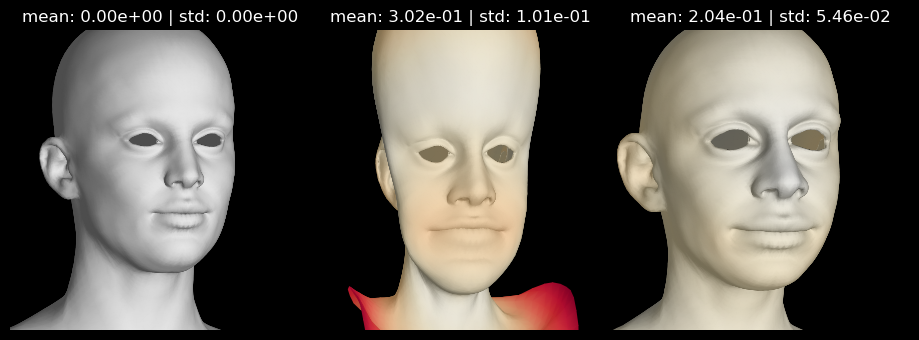

In [362]:
mesh_scale = .8
rot_list=[ [0,20,0] ]*len(v_list)

v_list1=[ 
        src_mesh.v,
        V_fitted,
        tgt_mesh.v,
    ]
f_list1=[ 
        src_mesh.f,
        src_mesh.f,
        tgt_mesh.f,
    ]
plot_mesh_gouraud(v_list1, f_list1, 
                     is_diff=True, diff_base=src_mesh.v, #diff_revert=True,
                     mesh_scale=mesh_scale,
                     rot_list=rot_list, size=SIZE, mode='shade')

In [ ]:
def all_loop(src_vert):
    return src_vert

# View

(11248,) 1.0 0.0
(11248,) 0.0 0.0


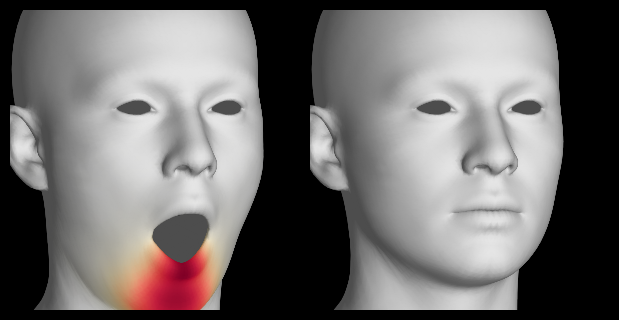

(11248,) 1.0 0.0
(11248,) 0.0 0.0


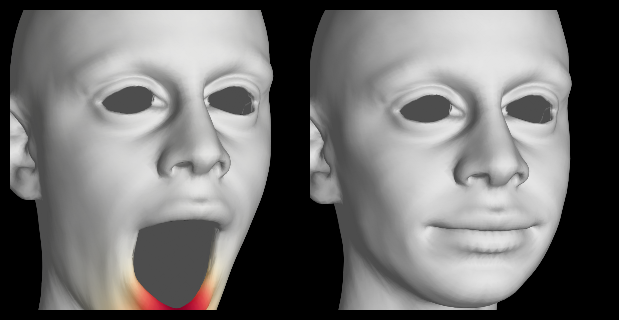

In [107]:

mesh_scale = 1
rot_list=[ [0,20,0] ]*len(v_list)

v_list1=[ 
        # src_mesh.motions[FRAME],
        blendshapes[BS]+src_mesh.v,
        src_mesh.v
    ]
f_list1=[ 
        src_mesh.f,
        src_mesh.f,
    ]
plot_mesh_gouraud(v_list1, f_list1, 
                     is_diff=True, diff_base=src_mesh.v, diff_revert=False,
                     mesh_scale=mesh_scale,
                     rot_list=rot_list, size=SIZE, mode='shade')

v_list2=[
    # V_transferred,
    V_transferred + recenter,
    tgt_mesh.v
    ]
f_list2=[ 
        tgt_mesh.f,
        src_mesh.f,
    ]
plot_mesh_gouraud(v_list2, f_list2, 
                     is_diff=True, diff_base=tgt_mesh.v, diff_revert=False,
                     mesh_scale=mesh_scale,
                     rot_list=rot_list, size=SIZE, mode='shade')

# Deformation Transfer using igl library
But more like delta mush..?

In [25]:

import igl
import numpy as np
import scipy.sparse.linalg as spla
from scipy.sparse import csr_array, csr_matrix, diags, vstack, hstack
from scipy.sparse.linalg import lsqr
from scipy.sparse.linalg import splu
from utils.ict_face_model import ICT_face_model
from easydict import EasyDict

tgt_mesh = EasyDict()
src_mesh = EasyDict()

print('loading meshes')
# src_mesh.v, src_mesh.f = igl.read_triangle_mesh("_tmp/m02_model.obj")
src_mesh.v, src_mesh.f = igl.read_triangle_mesh(r"data\source_restpose_mesh.obj")
print('\t src vertices:', src_mesh.v.shape, '\t faces:',src_mesh.f.shape) # (11248, 3) (22288, 3)

# # src_mesh.motions = np.load(r'_tmp\040.npy')
# src_mesh.motions = igl.read_triangle_mesh(r"data\source_deformed_mesh.obj")[0][None]
# print('\t src vertices (posed):', src_mesh.motions.shape) # (219, 11248, 3)
ict = ICT_face_model()
blendshapes = ict.exp_basis[:,:11248]
BS = 27
src_mesh.motions = blendshapes[BS]#np.load(r'_tmp\040.npy')

# newV, newF = igl.read_triangle_mesh("m02_deformed-0.2.obj")
newV, newF = igl.read_triangle_mesh(r"data\source_restpose_mesh.obj")
# newV, newF = igl.read_triangle_mesh("../002_mesh.obj")
newV = rescale(newV, src_mesh.v)

tgt_mesh.v = newV
tgt_mesh.f = newF
print('\t tgt vertices:', tgt_mesh.v.shape) # (219, 11248, 3)

ict = ICT_face_model()
blendshapes = ict.exp_basis[:,:11248]
print(blendshapes.shape)

loading meshes
	 src vertices: (11248, 3) 	 faces: (22288, 3)
	 tgt vertices: (11248, 3)
(53, 11248, 3)


Laplacian operator can be expressed as
$$

In [6]:
def mesh_area(mesh):
    target_fv = mesh.v[mesh.f]

    AB = target_fv[:, :, 1] - target_fv[:, :, 0]
    AC = target_fv[:, :, 2] - target_fv[:, :, 0]
    area = 0.5 * np.linalg.norm(np.cross(AB, AC), axis=-1)
    area_diag = np.repeat(area[:, np.newaxis], 3, axis=-1).reshape(-1)
    area = diags(area_diag)
    return area


## Precomputes

In [26]:
# source ###############
S_G = igl.grad(src_mesh.v, src_mesh.f) # sparse matrix
S_M = igl.massmatrix(src_mesh.v, src_mesh.f)
S_A = mesh_area(src_mesh)
L_S = S_G.T @ S_A @ S_G                # Approx. Laplacian
# L_S = S_G.T @ S_G                      # Approx. Laplacian
S_N = igl.per_vertex_normals(src_mesh.v, src_mesh.f)

# target ###############
T_G = igl.grad(tgt_mesh.v, tgt_mesh.f) # sparse matrix
T_M = igl.massmatrix(tgt_mesh.v, tgt_mesh.f)
T_A = mesh_area(tgt_mesh)
L_T = T_G.T @ T_A @ T_G                 # Approx. Laplacian
# L_T = T_G.T @ T_G                      # Approx. Laplacian
T_N = igl.per_vertex_normals(tgt_mesh.v, tgt_mesh.f)

T_M_I=spla.inv(T_M)
S_M_I=spla.inv(S_M)


In [150]:
# get_centroids(x)
R, t = procrustes_(S_N, T_N)

In [153]:
((S_M @ T_M_I) @ (blendshapes[BS])).shape

(11248, 3)

## RUN

In [27]:
#FRAME=150
BS = 11
# BS = 26
BShape = blendshapes[11] + blendshapes[26]
# displacement ###############
D_S = (S_M @ T_M_I) @ (BShape)
# D_S = (src_mesh.motions[FRAME] - src_mesh.v)
# D_S = (S_M @ T_M_I) @ (BShape+src_mesh.v - S_N)
#D_S = (S_M @ T_M_I) @ ((BShape+src_mesh.v) @ R.T - src_mesh.v) 
# D_S = ((BShape+src_mesh.v) @ R.T - src_mesh.v) 
# D_S = BShape #@ R.T
# D_S = blendshapes[BS]

# solve displacement!
b = L_S @ D_S
A = L_T

x = spla.spsolve(A, b)

# scale
# x = (S_M @ T_M_I) @ x

In [18]:
D_S.shape

(11248, 3)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


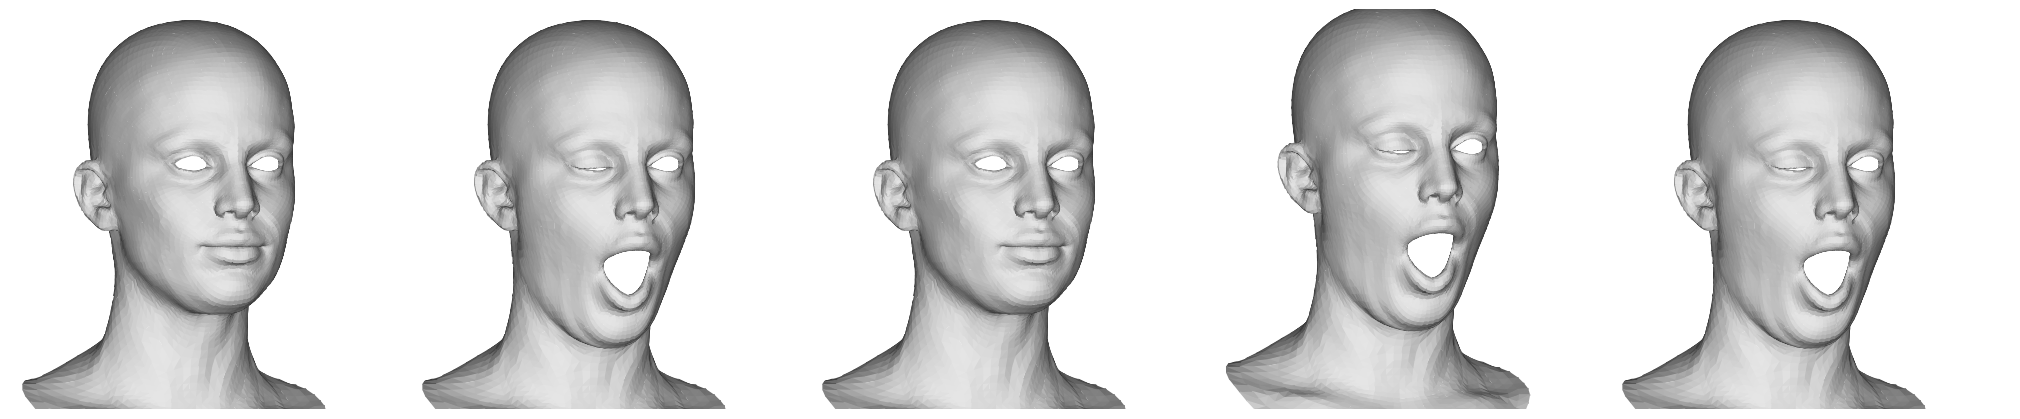

In [29]:
%load_ext autoreload
%autoreload 2
from matplotrender.src.matplotrender import plot_mesh_image
# figure size
SIZE = 4
mesh_scale = 0.68
# mesh_scale=1.2

# mesh that you wanna render
v_list=[ 
        src_mesh.v, 
        # src_mesh.motions[FRAME], 
        src_mesh.v + BShape,
        tgt_mesh.v, 
        x + tgt_mesh.v, 
        # (x-x.mean(0)) + tgt_mesh.v, 
        # (T_M_I @ S_M @ x) + tgt_mesh.v,
        # (S_M_I @ T_M @ x) + tgt_mesh.v,
        # tgt_mesh.v + (S_M @ T_M_I) @ BShape,
        tgt_mesh.v + BShape,
        # x_new,
        # x_bc, 
        # x_bc_new
    ]
v_list=[ v*mesh_scale for v in v_list]
f_list=[ 
        src_mesh.f,
        src_mesh.f,
        tgt_mesh.f,
        tgt_mesh.f,
        tgt_mesh.f,
        tgt_mesh.f,
    ]

# xyz Euler angle to rotate the mesh
rot_list=[ [0,20,0] ]*len(v_list)

# plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE)
# plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='normal')
plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='shade')

In [ ]:
def get_TBN_foreach_vertex(V, F):
    """
    Get TBN matrix for each vertex

    Args:
        V (np.ndarray): vertices (N, 3)
        F (np.ndarray): faces / trianlges (M, 3)

    Returns:
        np.ndarray: matrix (N, 3, 3)
        [
            [Tx, Ty, Tz],
            [Bx, By, Bz],
            [Nx, Ny, Nz],
        ]
    """
    Vn = igl.per_vertex_normals(V, F)
    
    al = igl.adjacency_list(F) # all neighbors
    nb = [nbrs[0] for nbrs in al] # select one

    Vt_nb = V[nb] - V
    Vt_nb = Vt_nb/np.linalg.norm(Vt_nb, axis=1)[:,None]

    # project
    _Vt = np.sum(Vt_nb * Vn, axis=1, keepdims=True)
        
    Vt = (Vt_nb - _Vt * Vn)
    Vt = Vt/np.linalg.norm(Vt, axis=1)[:,None]
    
    Vb = np.cross(Vn, Vt)
    Vb = Vb/np.linalg.norm(Vb, axis=1)[:,None]
    
    return np.concatenate([
        Vt[:,None], 
        Vb[:,None],
        Vn[:,None], 
    ], axis=1)

In [ ]:
V_TBN = get_TBN_foreach_vertex(V, F) 
newV_TBN = get_TBN_foreach_vertex(newV, F)
MAT = np.einsum('bcn, bnk->bck', newV_TBN, V_TBN.transpose(0,2,1))

new_displacements = np.einsum('vcn, bvn->bvc', MAT, D_S)
print(new_displacements.shape, new_displacements.max())

In [239]:
qwe = trimesh.Trimesh(vertices=src_mesh.v + BShape, faces=src_mesh.f)
asd = trimesh.Trimesh(vertices=src_mesh.v, faces=src_mesh.f)
zxc = trimesh.Trimesh(vertices=tgt_mesh.v, faces=tgt_mesh.f)
_ = asd.export('source_restpose_mesh.obj')
_ = qwe.export('source_deformed_mesh.obj')
_ = zxc.export('target_restpose_mesh.obj')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


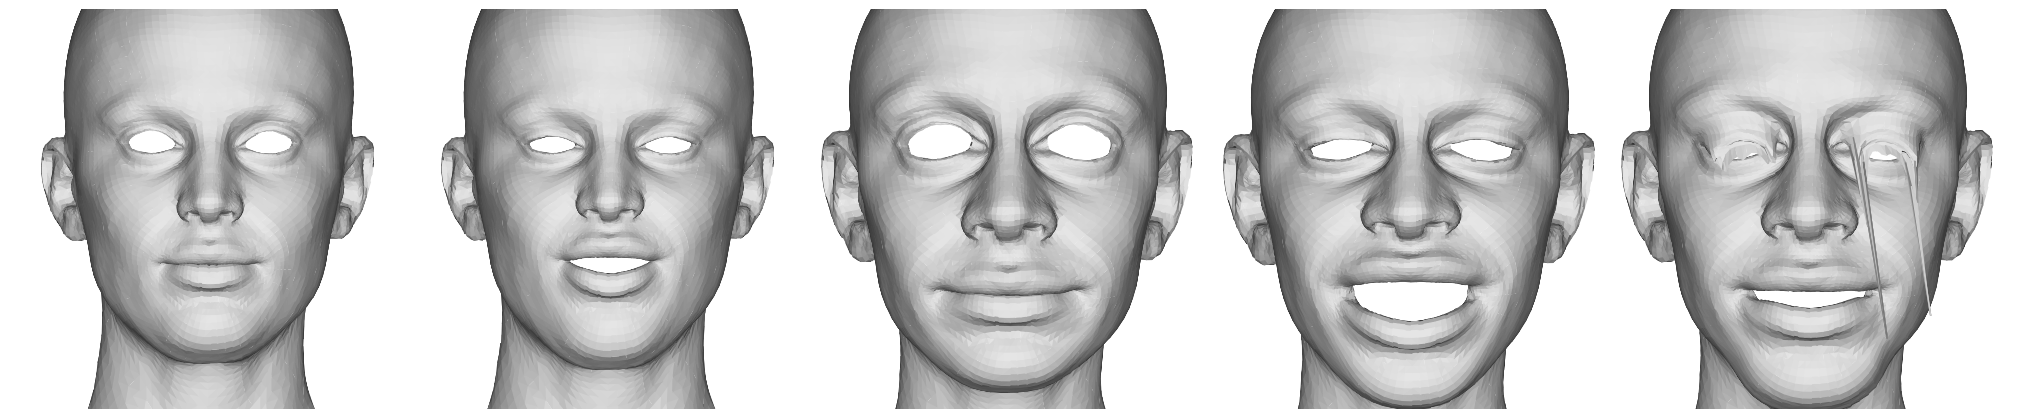

In [55]:
%load_ext autoreload
%autoreload 2
from matplotrender import *
# figure size
SIZE = 4
# mesh_scale = 0.6
mesh_scale=1

# mesh that you wanna render
v_list=[ 
        src_mesh.v, 
        src_mesh.motions[FRAME], 
        tgt_mesh.v, 
        x + tgt_mesh.v, 
        (x/x_len*s_len) + tgt_mesh.v, 
        # x_new,
        # x_bc, 
        # x_bc_new
    ]
v_list=[ v*mesh_scale for v in v_list]
f_list=[ 
        src_mesh.f,
        src_mesh.f,
        tgt_mesh.f,
        tgt_mesh.f,
        tgt_mesh.f,
    ]

# xyz Euler angle to rotate the mesh
rot_list=[ [0,0,0] ]*len(v_list)

# plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE)
# plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='normal')
plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='shade')

(11248,) 0.04440434231665857 3.2272350549557542e-09
(11248,) 1.0 0.0


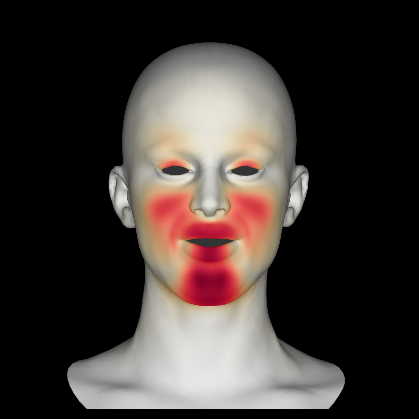

(11248,) 0.12307528615263995 0.0007814115155675175
(11248,) 1.0 0.0


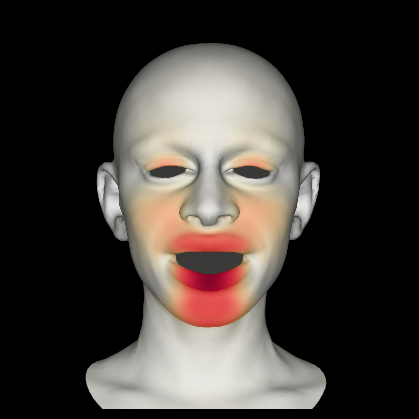

In [37]:

v_list1=[ 
        src_mesh.motions[FRAME],
    ]
diff_list1=[
        src_mesh.motions[FRAME]-src_mesh.v, 
    ]
v_list1=[ v*mesh_scale for v in v_list1]
f_list1=[ 
        src_mesh.f,
    ]
plot_image_array_grd(v_list1, f_list, 
                     diff_list1, is_diff=True, diff_base=src_mesh.v,
                     rot_list=rot_list, size=SIZE, mode='shade')

v_list2=[
    # x + tgt_mesh.v
    (x-x.mean(0,keepdims=True)) + tgt_mesh.v,
    ]
diff_list2=[
    # x
    (x-x.mean(0,keepdims=True)),
    ]
v_list2=[ v*mesh_scale for v in v_list2]
f_list1=[ 
        tgt_mesh.f,
    ]
plot_image_array_grd(v_list2, f_list, 
                     diff_list2, is_diff=True, diff_base=tgt_mesh.v,
                     rot_list=rot_list, size=SIZE, mode='shade')

In [149]:
def compute_average_distance(points, mode='np'):
    """Compute the average Euclidean distance from the origin for a set of points.

    Args
    -------
        points (np.ndarray / torch.tensor): [V, 3] A set of points.
        mode (str): choose between np (numpy) and torch

    Return
    -------
        average_distance (np/torch): Average Euclidean distance.
    """
    if mode=='np':
        distances = np.linalg.norm(points, axis=1)
        average_distance = np.mean(distances)
    else:
        distances = torch.linalg.norm(points, axis=1)
        average_distance = torch.mean(distances)
    return average_distance

def procrustes_(P, Q, LDM=None, mode='np'):
    """# Q = P@R.T+t
    [P->Q] Find the optimal rotation, translation, and scaling
    that aligns two sets of points P and Q minimizing using landmarks.
    
    Args
    -------
        P (np.ndarray): [V, 3] A set of source points.
        Q (np.ndarray): [V, 3] A set of corresponding target points.

    Returns
    ------- 
        R (np.ndarray): Rotation matrix (R)
        t (np.ndarray): translation vector (t)
        s (np.ndarray): scale factor (s)
    """
    if mode=='np':
        helper = np
    else:
        helper = torch
        
    if LDM is not None:
        P = P[LDM]
        Q = Q[LDM]
    
    # Calculate the centroids of the point sets
    centroid_P = helper.mean(P, axis=0)
    centroid_Q = helper.mean(Q, axis=0)
    
    # Center the points around the origin
    P_centered = P - centroid_P
    Q_centered = Q - centroid_Q

    # Compute the covariance matrix
    H = P_centered.T @ Q_centered

    # Perform Singular Value Decomposition
    U, S, Vt = helper.linalg.svd(H)
    
    # Compute the rotation matrix
    R = Vt.T @ U.T

    # Special reflection case
    if helper.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = Vt.T @ U.T

    # Compute the translation vector
    t = centroid_Q - R @ (centroid_P)

    return R, t

In [53]:
L_S

tensor(indices=tensor([[    0,     1,     2,  ...,  9679, 11043, 11247],
                       [    0,     1,     2,  ..., 11043, 11156, 11247]]),
       values=tensor([-1.0000, -1.0000, -1.0000,  ...,  0.0833,  0.0833,
                      -1.0000]),
       size=(11248, 11248), nnz=144976, layout=torch.sparse_coo)

In [51]:
L_S.coalesce()

tensor(indices=tensor([[    0,     0,     0,  ..., 11247, 11247, 11247],
                       [    0,     2,   171,  ..., 11239, 11246, 11247]]),
       values=tensor([-1.0000,  0.1667,  0.1667,  ...,  0.5000,  0.2500,
                      -1.0000]),
       size=(11248, 11248), nnz=78324, layout=torch.sparse_coo)

In [38]:
print(S_G)

  (415, 0)	57.88253904082016
  (2533, 0)	8.867121581495
  (6126, 0)	-59.046580155311176
  (11559, 0)	-7.721789893164439
  (13677, 0)	-58.21530879360827
  (16752, 0)	55.8769565664605
  (22703, 0)	-1.2658291731230547
  (24821, 0)	-57.036221116858904
  (28414, 0)	46.95048223036222
  (33847, 0)	-57.34852685029324
  (35965, 0)	-2.903993175503608
  (39040, 0)	47.03884828396855
  (44991, 0)	8.604447493639912
  (47109, 0)	15.729138329462055
  (50702, 0)	16.702876212056793
  (56135, 0)	14.826422053889791
  (58253, 0)	3.86029072684607
  (61328, 0)	20.335710727423205
  (2479, 1)	-87.77968016970478
  (4361, 1)	-85.46021798647645
  (11505, 1)	86.572520134433
  (15506, 1)	95.6490158623694
  (24767, 1)	-62.274398788208956
  (26649, 1)	21.913566447542635
  (33793, 1)	-53.216942397543164
  :	:
  (22274, 11245)	1.5931882898125063
  (33418, 11245)	-2.088281005953583
  (33419, 11245)	-3.7144426725808337
  (44562, 11245)	-5.341222700081844
  (55706, 11245)	-5.036607654840957
  (55707, 11245)	-3.61461085735

In [44]:
x = lsqr(L_T.numpy(), C[:,0].numpy())
# y = lsqr(L_T, C[:,0])[0]
# z = lsqr(L_T, C[:,0])[0]
# x = x.reshape(-1, 3)
# print(x.min(0), x.max(0))


# lu = lu_factor_ata(L_T)
# Atb = A.T @ S.reshape(-1)
# x = lu.solve(Atb)

TypeError: can't convert Sparse layout tensor to numpy.convert the tensor to a strided layout first.

In [30]:
def compute_face_gradient(V, F, f):
    grads = np.zeros((F.shape[0], 3))
    for i, face in enumerate(F):
        v0, v1, v2 = V[face]
        f0, f1, f2 = f[face]

        e1 = v1 - v0
        e2 = v2 - v0

        normal = np.cross(e1, e2)
        area = 0.5 * np.linalg.norm(normal)
        normal /= (2 * area + 1e-8)

        g = ((f1 - f0) * np.cross(normal, v2 - v0) +
             (f2 - f0) * np.cross(v0 - v1, normal)) / (2 * area + 1e-8)

        grads[i] = g

    return grads


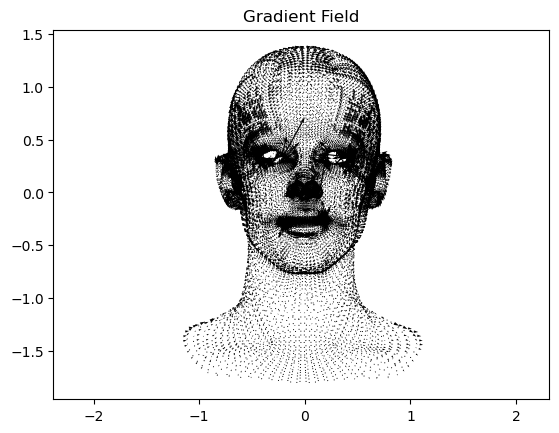

In [ ]:
import trimesh
import matplotlib.pyplot as plt

# 임의 메쉬 및 스칼라 함수
# mesh = trimesh.creation.icosphere()


vertices, faces = igl.read_triangle_mesh("_tmp/m02_model.obj")

mesh = trimesh.Trimesh(vertices=vertices,faces=faces)
V, F = mesh.vertices, mesh.faces
f = V[:, 2]  # z값을 스칼라 함수로 사용

grads = compute_face_gradient(V, F, f)

# 각 삼각형의 중심 계산
centroids = V[F].mean(axis=1)

# 시각화 (matplotlib)
# mesh.show()  # 3D 뷰

# 또는 2D quiver plot
plt.quiver(centroids[:,0], centroids[:,1], grads[:,0], grads[:,1])
plt.axis('equal')
plt.title('Gradient Field')
plt.show()


In [35]:
grads.shape

(22288, 3)

In [92]:
import scipy
import igl
import numpy as np
from scipy.sparse.linalg import spsolve
from scipy.sparse import  diags
# from meshplot import plot, subplot, interact

# v, f = igl.read_triangle_mesh("_tmp/m02_model.obj")
v, f = igl.read_triangle_mesh(r"data\source_restpose_mesh.obj")

## Find boundary vertices
e = igl.boundary_facets(f)
v_b = np.unique(e)

## List of all vertex indices
v_all = np.arange(v.shape[0])

## List of interior indices
v_in = np.setdiff1d(v_all, v_b)

## Construct and slice up Laplacian
l = igl.cotmatrix(v, f)
l_ii = l[v_in, :]
l_ii = l_ii[:, v_in]

l_ib = l[v_in, :]
l_ib = l_ib[:, v_b]

## Dirichlet boundary conditions from z-coordinate
z = v[:, 2]
bc = z[v_b]

## Solve PDE
z_in = spsolve(-l_ii, l_ib.dot(bc))

print(z_in.shape)
# plot(v, f, z)

3


c:\Users\sihun\anaconda3\envs\pytorch\lib\site-packages\numpy\lib\arraysetops.py:270: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)


ValueError: could not broadcast input array from shape (212,2) into shape (212,)

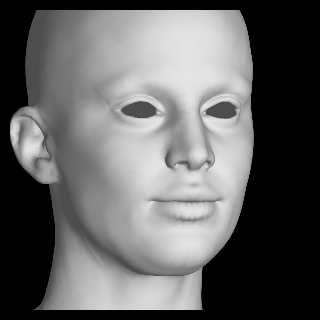

In [12]:
v_list2=[v]
diff_list2=[torch.tensor(z_in)]
f_list2=[f]
rot_list=[ [0,20,0] ]*len(v_list2)
plot_mesh_gouraud(v_list2, f_list2, 
                  #diff_list2, is_diff=True, diff_base=tgt_mesh.v,
                  rot_list=rot_list, size=3, mode='shade')

In [82]:

def smooth(vert, lap, loop=1, t=0.01):
    D_Inv = diags(1 / lap.diagonal())
    _lap = D_Inv @ lap
    
    # a = 1-t
    I_L = scipy.sparse.identity(lap.shape[0]) - _lap*t
    # I_L = (I_L*t).power(loop)
    for i in range(loop):
        I_L = I_L @ I_L
    
    vert = I_L @ vert
    return vert

In [92]:
l.toarray()
D_Inv = diags(1 / l.diagonal())
_lap = D_Inv @ l
# -_lap.toarray()
asd=  scipy.sparse.identity(_lap.shape[0])-_lap*0.53
# asd=asd*.1
# asd=asd @ asd
asd.toarray()

array([[0.47      , 0.        , 0.14466531, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.47      , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.14495706, 0.        , 0.47      , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.47      , 0.06337022,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.05464159, 0.47      ,
        0.11676362],
       [0.        , 0.        , 0.        , ..., 0.        , 0.11341957,
        0.47      ]])

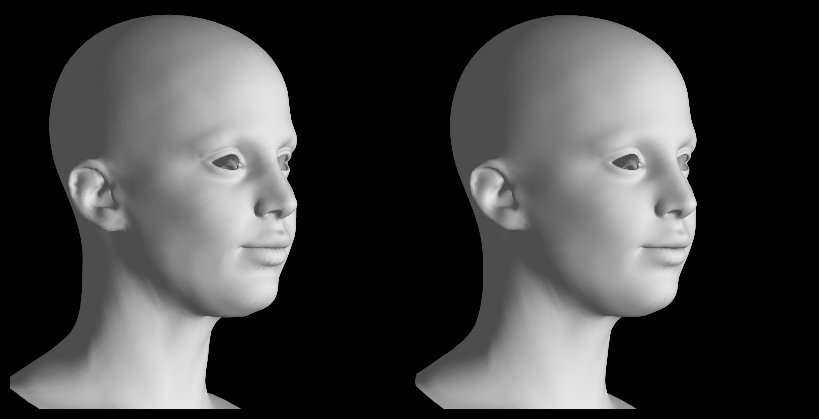

In [97]:
l = igl.cotmatrix(v, f)

vv = smooth(v, l, loop=4, t=0.1)
v_list2=[v, vv]

# v_list2=[v]

# diff_list2=[torch.tensor(z_in)]
f_list2=[f,f]
rot_list=[ [0,50,0] ]*len(v_list2)
plot_mesh_gouraud(v_list2, f_list2, 
                  #diff_list2, is_diff=True, diff_base=tgt_mesh.v,
                  rot_list=rot_list, size=4, mode='shade', mesh_scale=.7)

In [67]:
v-vv

array([[-1.14477360e-06, -9.75689049e-08,  3.06708775e-05],
       [ 9.67322233e-07, -1.03216951e-05, -8.57590897e-06],
       [-1.68050251e-06,  1.31471914e-05,  2.35897362e-05],
       ...,
       [ 1.25262577e-04, -4.69591310e-04, -6.41599250e-04],
       [ 6.75705609e-05, -4.91371724e-04, -5.97257610e-04],
       [ 2.90396888e-05, -5.47667548e-04, -5.52774756e-04]])